<a href="https://colab.research.google.com/github/Zeta-num/CHEM101.6/blob/main/solved_CHEM101.6_Exercise_0_Butane_OpenMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello there!**

This is a Jupyter notebook for running Molecular Dynamics (MD) simulations of Alkanes using the OpenMM engine 

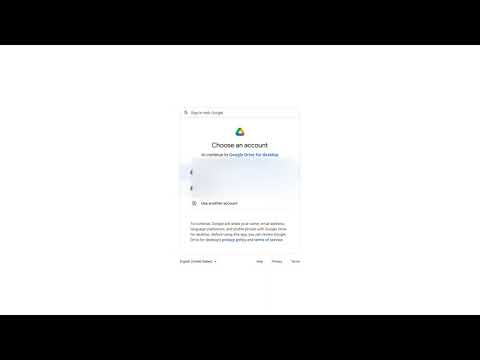

In [1]:
#@title ### **Video Demonstration**
#@markdown Check the timelapse movie to understand how the pipeline works
from IPython.display import YouTubeVideo
YouTubeVideo('pVa0mQS6xeo', width=800, height=500)

---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    Anaconda (https://docs.conda.io/en/latest/miniconda.html)
2.    OpenMM (https://openmm.org/)
3.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
4.    py3Dmol (https://pypi.org/project/py3Dmol/)
5.    Numpy (https://numpy.org/)
6.    Matplotlib (https://matplotlib.org/)
7.    AmberTools (https://ambermd.org/AmberTools.php)

In [2]:
# install dependencies
!pip -q install py3Dmol 2>&1 1>/dev/null
!pip install --upgrade MDAnalysis 2>&1 1>/dev/null
!pip install biopandas 2>&1 1>/dev/null
# install conda
!wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh 
!bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
!rm Miniconda3-latest-Linux-x86_64.sh
!conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer 2>&1 1>/dev/null
!conda install -c conda-forge ambertools --yes 2>&1 1>/dev/null
!conda install -c ambermd pytraj  --yes 2>&1 1>/dev/null


In [3]:
#load dependencies
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [4]:
from openmm import *

In [5]:
from openmm.app import *

In [6]:
from openmm.unit import *

In [7]:
from __future__ import print_function

In [8]:
from biopandas.pdb import PandasPdb
import openmm as mm
import os
import urllib.request  
import numpy as np
import MDAnalysis as mda
import py3Dmol
import pytraj as pt
import platform
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
import seaborn as sb
from statistics import mean, stdev
from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats
#%matplotlib inline
#set_matplotlib_formats('png')
#plt.figure(figsize=(5,7))

## Using Google Drive to store simulation data

Google Colab does not allow users to keep data on their computing nodes. However, we can use Google Drive to read, write, and store our simulations files. Therefore, we suggest to you to:

1.   Create a folder in your own Google Drive and copy the necessary input files there.
2.   Copy the path of your created directory. We will use it below.

In [9]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [10]:
#@title **Check if you correctly allocated GPU nodes**

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Oct 19 14:46:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
from simtk import unit
from openmm import app

#Lets Load in our Butane Molecule and Force Field from Our Google Drive
PDB_file_name = 'butane.pdb'
forcefield_file_name = 'butane.gaff2.cor1.xml' 
Google_Drive_Path = '/content/drive/MyDrive/CHEM_data'
workDir = Google_Drive_Path
initial_pdb = os.path.join(workDir, str(PDB_file_name))
force_field = os.path.join(workDir,str(forcefield_file_name))
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/content/drive/MyDrive/CHEM_data/butane.pdb
/content/drive/MyDrive/CHEM_data/butane.gaff2.cor1.xml


In [12]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 13.762958847842143 kJ/mol
Potential energy after minimization is 7.550914791028611 kJ/mol


In [13]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,26.63505531313986,216.883421350769
200,38.059325877585465,297.7247357532534
300,51.839862092488566,248.54537689574065
400,33.5974308671495,215.4248982049862
500,43.88031450260891,228.4706726938762
600,38.93240031068099,316.7278423305226
700,58.88711971407593,242.06781714389155
800,40.466955280420535,320.22730747106334
900,33.15599281404636,365.34148821432785
1000,31.928671748179426,283.2921190999684
1100,27.09990138751918,270.9515490332512
1200,36.011692228268934,271.1968567533112
1300,32.86421358796464,255.10436458682895
1400,55.75209761776914,256.24226162144475
1500,44.61251296048829,243.84005188425732
1600,38.65239321286691,245.0596121582181
1700,36.49722372554046,381.54887490557667
1800,41.423598991805676,276.25754514560373
1900,53.18315106347674,318.38210578775835
2000,35.28325573185579,305.46520153439826
2100,41.05363213300123,244.07257891748728
2200,33.48957118026109,248.9944447474754
2300,45.53460000581

In [14]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,28.88958543550185,423.50888617751656,0
500000,999.9999999901769,31.102339572400936,192.57049244891508,1.32e+04
750000,1499.9999999783536,59.911070660217085,360.422873058961,1.32e+04
1000000,1999.9999999665301,47.79591227399778,307.6581329946004,1.3e+04
1250000,2499.9999999547067,40.277653249676995,348.78172967842164,1.3e+04
1500000,2999.9999999428833,49.55417596320598,181.34966892184897,1.3e+04
1750000,3499.99999993106,30.902945048247403,277.9043910679969,1.3e+04
2000000,3999.9999999192364,66.82102533508571,323.2509041891356,1.29e+04
2250000,4499.9999999992715,42.11781234267845,349.94822225810316,1.29e+04
2500000,5000.000000101135,39.503236114116724,343.8477348110716,1.3e+04
2750000,5500.000000202998,57.073826307533004,233.58433188587452,1.29e+04
3000000,6000.000000304862,36.690487023145295,201.89448783727553,1.29e+04
3250000,6500.000000406725,35.2468474456

In [15]:
!pip install nglview 2>&1 1>/dev/null
!conda install -c conda-forge mdtraj  --yes 2>&1 1>/dev/null

In [16]:
import mdtraj as md
traj = md.load('butane_sim.dcd', top=initial_pdb)


In [17]:
import ipywidgets
from ipywidgets import interact, fixed
import warnings
warnings.filterwarnings('ignore')
from google.colab import output
output.enable_custom_widget_manager()

import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=99999)

In [18]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,0,NBU,0,
1,2,C2,C,0,NBU,0,
2,3,C3,C,0,NBU,0,
3,4,C4,C,0,NBU,0,
4,5,H11,H,0,NBU,0,
5,6,H12,H,0,NBU,0,
6,7,H13,H,0,NBU,0,
7,8,H21,H,0,NBU,0,
8,9,H22,H,0,NBU,0,
9,10,H31,H,0,NBU,0,


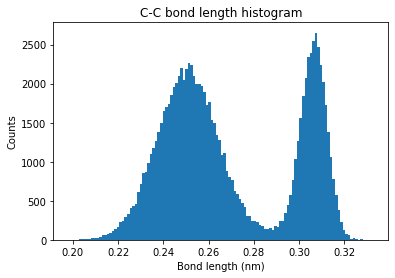

In [29]:
bond_indices = [4, 7] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

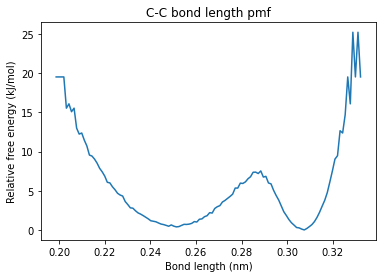

In [20]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
bondcounts[bondcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(bondcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

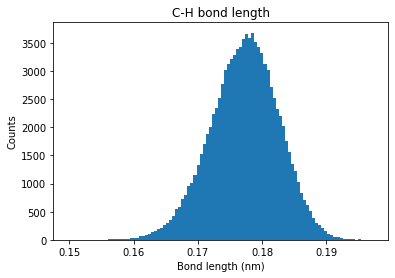

In [21]:
bond_indices = [4, 5] # many possibilities!
bondlength = md.compute_distances(traj, [bond_indices])

lengthcounts, binedges, otherstuff = plt.hist(bondlength, bins=100)
plt.title('C-H bond length')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

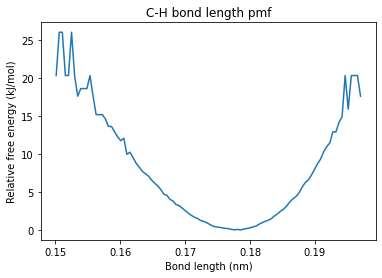

In [22]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
lengthcounts[lengthcounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(lengthcounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-H bond length pmf')
plt.show()

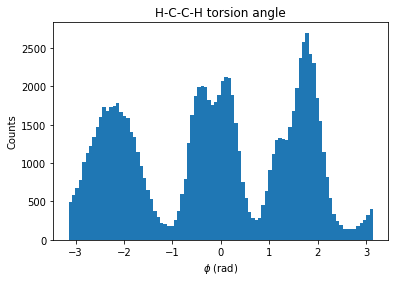

In [23]:
phi_indices = [0, 4, 7, 10] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=90) # create a histogram with 90 bins
plt.title('H-C-C-H torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

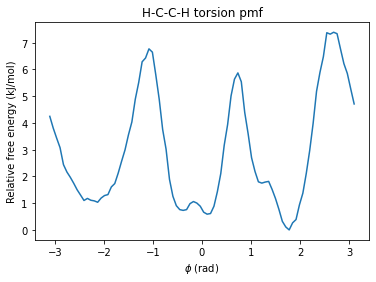

In [24]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

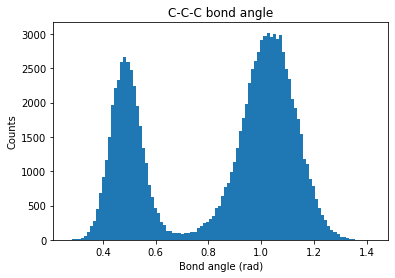

In [25]:
angle_indices = [0, 4, 7] # or could do [4, 7, 10]
bondangle = md.compute_angles(traj, [angle_indices])

anglecounts, binedges, otherstuff = plt.hist(bondangle, bins=100)
plt.title('C-C-C bond angle')
plt.xlabel('Bond angle (rad)')
plt.ylabel('Counts')
plt.show()

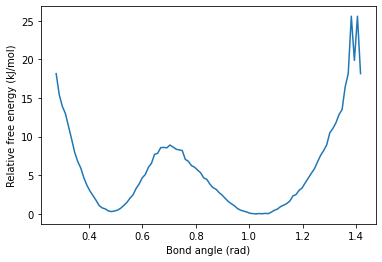

In [26]:
anglecounts[anglecounts==0] = 0.1
pmf = -kB*Temp*np.log(anglecounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2


plt.plot(bincenters, pmf)
plt.xlabel('Bond angle (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()